# Social Computing/Social Gaming - Summer 2025

# Exercise Sheet 4: Sentiment Analysis in Dota 2

In this exercise we will work with data gathered from the popular MOBA *Defense of the Ancients 2*, or short Dota 2, developed by Valve in 2013. If you are unfamiliar with this game, we provide a short introduction that should be enough to make you understand what the tasks demand from you:

In Dota 2, two teams of 5 players play against each other on a single map, each team trying to destroy the enemy base, also called the ancient. In order to do this, they try to kill each other, earn gold and experience by killing non-player characters called creeps to gain an advantage over the enemy. In every match, players first choose from a pool of 126 different heroes, which are roughly divided into 2 groups: Carries, who start out weak and become much stronger once they accumulate a sufficient amount of gold to buy items they need, and supports, who protect the carries in the early stages of a match, but tend to become less relevant in the later stages. Every team needs a balanced hero selection in order to have a chance of winning, as too many carries will have that team face a disadvantage early on, while too many supports may cause that team to struggle to win the game even once an advantage has been secured early.

Psychologically speaking, Dota - or any MOBA for that matter - is an experiment on successful team formation and cooperation, as 5 strangers meet each other for one match with the same goal, but usually different views on how to achieve it. Its real-world equivalent would be any mash-up of people forced to work in a group, the only difference being that usually real-life situations don't involve another group working against them. 

Needless to say, the nature of the game does provoke negativity at times, and we want to try to predict it. More precisely, we want to find out whether we can infer negative player behavior from modeling the state of a game as a set of values.

The .csv files provided for you contain information from 1.500 matches played during December 2016, and are split into 5 tables: 

- **chat.csv**: This table contains information about what was said in the chat between teams, when it was said, and which player said it. We need the 'key', 'time' and 'slot' column as we are only interested in which team the players belong to, not their identities.
- **match.csv**: Contains information about the game results. We only need the 'radiant_win' column from it, which tells us which team won.
- **players.csv**: Detailed statistics for every player. 'kills' and 'deaths' columns are needed as we will need them to determine underperforming players.
- **player_times.csv**: Among other things the gold accumulated by every player, for every minute of a match, used to calculate the difference in gold earned between these teams.
- **labels.csv**: A sample of labeled chat used for the sentiment analysis.

## Import needed libraries for assignment

In [47]:
# Import libraries needed for sentiment analysis
import numpy as np 
import pandas as pd
import re
import nltk 
import matplotlib.pyplot as plt
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn import  svm 
from sklearn.linear_model import LinearRegression
from statistics import mean
from sklearn import linear_model

## Task 4.1 - Your first sentiment analysis

Sentiment analysis, sometimes called opinion mining, is a method to derive information from the text that allows for a classification as neutral, positive or negative. It is a semi-supervised process, meaning that you need a small set of labeled data to train your machine learning model on in order to use it on another set of unlabeled data. As the model is trained on the labeled set, it learns which input to classify as 'positive', 'neutral', or 'negative'. More subtle differences might only become distinguishable for the model with a larger size of the training set, so as a basic rule you could say: The bigger the training set, the better the classifier can perform. Some of its many practical applications are the analysis of customer reviews, social media comments, or survey responses.

**Note:** We will use a random forest classifier in this task.

Your task is to **train a model using the labeled data**, then use that model to predict the sentiments of the whole chat. Let us start with the basics:

### a) Preparation

**Import** the labels and split them into two arrays: the chat itself and the labels.

A label is like a review of a single message:  
-1 = negative  
 0 = neutral   
 1 = positive

In [48]:
# Import "labels.csv" and split it into 2 arrays: chat and labels.
df = pd.read_csv('dataset/labels.csv')
print(df.info())
chat = df['Chat message'].values
labels = df['Label'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Chat message  475 non-null    object
 1   Label         475 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB
None


### b) How to train your model

In this step you will use the chat and labels to **train your random forest classifier**. In order to do so, **create** the random forest classifier, **fit** it and **make a prediction** on the test set.

After you are done, print the accuracy score and comment on it.

**Hints:**
- When creating the classifier, use `n_estimators=200`, `random_state=0` as arguments.
- The test should be 20% of the whole set

In [49]:
# There are some words which do not have any valuable classification information. 
# We will use 'stopwords' to get rid of them.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiarapiccolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
chat_data = [str (item) for item in chat]
vectorizer = TfidfVectorizer (max_features=2500, min_df=3, max_df=0.8, stop_words=stopwords.words('english'))
chat_data = vectorizer.fit_transform(chat_data).toarray()

# Create the random forest classifier, fit it and make a prediction on the test set.
X_train, X_test, y_train, y_test = train_test_split(chat_data, labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print(f"Confusion Matrix:\n{confusion_matrix(y_test,predictions)}\n")
print(f"Classification report:\n{classification_report(y_test,predictions)}\n")
print(f"Accuracy Score:\n{accuracy_score(y_test, predictions)}")

Confusion Matrix:
[[ 9 28  0]
 [ 0 50  3]
 [ 0  5  0]]

Classification report:
              precision    recall  f1-score   support

    negative       1.00      0.24      0.39        37
     neutral       0.60      0.94      0.74        53
    positive       0.00      0.00      0.00         5

    accuracy                           0.62        95
   macro avg       0.53      0.40      0.38        95
weighted avg       0.73      0.62      0.56        95


Accuracy Score:
0.6210526315789474


**Write your observations here:** The model’s accuracy is moderate (62%), but the confusion matrix shows very different performance across classes.

For the positive class, all scores are 0: the model failed to recognize any positive messages. This likely happens because there are very few positive examples in the data.

For the negative class, the precision is high (1.00) but the recall is low (0.24). This means that when the model says a message is negative, it is correct, but it misses many negative messages.

The neutral class is handled better: recall is high (0.94), so most neutral messages are correctly found. But precision is low (0.60), meaning the model also marks non-neutral messages as neutral. This shows the model is biased toward the neutral class, probably because it is the most common. When uncertain, the model tends to pick “neutral”.

### c) Prediction time:

Now you can use the model to **predict the sentiments** for the whole chat. Import the chat and **predict the labels**. You will need to use `vectorizer.transform().toarray()` on your data, but **do not** use `fit()` anywhere! The classifier is already fitted, fitting it again effectively erases all it has learned.

**Note:** The chat table is massive. Labelling all of it may take a while.

In [51]:
chatData = pd.read_csv("dataset/chat.csv")
print(chatData.info())
unlabeled = chatData.iloc[:,1].values
unlabeled = chatData['key'].iloc[475:].fillna("").values
print(len(unlabeled))

# We remove the first 475 entries as they are the ones contained in our labeled training set,
# so we will rather use their original hand made labels.

X_unlabeled = vectorizer.transform(unlabeled).toarray()
predicted_labels = clf.predict(X_unlabeled)
print(predicted_labels[:10])

len(predicted_labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46744 entries, 0 to 46743
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   match_id  46744 non-null  int64 
 1   key       46743 non-null  object
 2   slot      46744 non-null  int64 
 3   time      46744 non-null  int64 
 4   unit      46731 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.8+ MB
None
46269
['neutral' 'negative' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'positive' 'negative' 'neutral']


46269

## Task 4.2 - Linear regression

Linear regression is a technique that tries to find a correlation between a set of input variables x and a dependant variable y. In mathematical terms:

$$y = \alpha + \beta X + \epsilon$$

where:
- $X$ is the predictive vector, containing the (predictive) variables
- $\alpha$ and $\beta$ are the model's parameters, where $\alpha$ is the intercept/bias, $\beta$ the coefficient vector containing coefficients for each predictive variable
- and $\epsilon$ the prediction error.

Note that the assumption made is that the relationship is linear. This is a special case of polynomial regression, where we would allow for e.g. squared relationships.

Our dependant variable is the negativity in the chat. Therefore we need to convert our labels into numbers first: We will use 0 for neutral, -1 for negative and +1 for positive sentiments. This is, of course, a simplification, as not all negative statements are equally negative. But we need to acknowledge that it is simply impossible to make an accurate distinction without knowing any context. And if we knew that, there would be no point in doing this regression.

In [52]:
# Convert the labels into values
# First we add the hand made labels for the first 475 entries
sentiments = []
for i in labels:
    if i == 'positive':
        sentiments.append(1)
    elif i == 'negative':
        sentiments.append(-1)
    else:
        sentiments.append(0)

In [53]:
# Now we add our predicted labels
for i in predicted_labels:
    if i == 'positive':
        sentiments.append(1)
    elif i == 'negative':
        sentiments.append(-1)
    elif i == 'neutral':
        sentiments.append(0)

In [54]:
print(len(chatData))   
print(len(labels))             
print(len(predicted_labels))        

46744
475
46269


### a) Preparation:

First, we need to **read the .csv files** and group them by `match_id`.

**1.** **Create a dataframe** containing all relevant information where each row represents one match. An empty dataframe has already been created for you with all the columns you need to fill. 


In [55]:
# Read the csv files and group them by match id
chatData = pd.read_csv("dataset/chat.csv")
chatData = chatData.drop(['unit'],axis=1)
chatData['label'] = sentiments # We are adding the labels to the chat messages
chatData = chatData.groupby('match_id')
print(chatData.head())

player_times = pd.read_csv("dataset/player_time.csv")
player_times = player_times.groupby('match_id')
print(player_times.head())  

match_info = pd.read_csv("dataset/match.csv")
radiant_win = match_info['radiant_win']
print(radiant_win.head())

player_info = pd.read_csv("dataset/players.csv")
player_info = player_info[['match_id', 'kills','deaths']]
player_info = player_info.groupby('match_id')
print(player_info.head())

       match_id            key  slot  time  label
0             0       force it     6    -8      0
1             0  space created     1     5      0
2             0            hah     1     6      0
3             0         ez 500     6     9     -1
4             0       mvp ulti     4   934      0
...         ...            ...   ...   ...    ...
46737      1500              g     2   -83      0
46738      1500              g     6   -83      0
46739      1500              g     9   -83      0
46740      1500           ggwp     5  1660      0
46741      1500             gg     4  1666      0

[7320 rows x 5 columns]


       match_id  times  gold_t_0  lh_t_0  xp_t_0  gold_t_1  lh_t_1  xp_t_1  \
0             0      0         0       0       0         0       0       0   
1             0     60       409       0      63       142       1     186   
2             0    120       546       0     283       622       4     645   
3             0    180       683       1     314       927       9    1202   
4             0    240       956       1     485      1264      11    1583   
...         ...    ...       ...     ...     ...       ...     ...     ...   
66995      1500      0         0       0       0         0       0       0   
66996      1500     60       100       0     102       226       3     102   
66997      1500    120       200       0     235       532       8     317   
66998      1500    180       300       0     235       838      13     492   
66999      1500    240       400       0     310      1217      19     813   

       gold_t_2  lh_t_2  ...  xp_t_129  gold_t_130  lh_t_130  x

In [56]:
# Create the dataframe with the columns chatData, goldData, KDratios and radiant_win
dataframe = pd.DataFrame(columns=['chatData', 'goldData', 'KDratios', 'radiant_win'])


**2.** **Create a list of lists of lists** called `full_chatdata`, with a tuple for each message, with label and team (you can see an example in the comments).


**Hints:**

- you can find the labels in the chatData dataframe
- use the `slot` column to determine the team. 0 to 4 is for radiant, 5-9 is for dire

In [57]:
# 2.
full_chatdata = []

for name, group in chatData:
    chat_data_line = []
    for index,row in group.iterrows():
        chat_tuple = []
        # Create a list of lists of lists called full_chatdata, with a tuple for each message, with label and team.
        # It should look something like this:
        '''
        [
            [ [0, 'dire'], [0, 'radiant'], [1, 'radiant'] ], 
            [ [0,'radiant'], [0, 'dire'], [-1, 'dire'], [0, 'dire'], [0, 'radiant'], [1, 'radiant'], [0, 'radiant'] ]
        ]
        '''
        # Hint 1: use the label column to determine the negativity/positivity of the message
        # Hint 2: use the 'slot' column to determine the team. 0 to 4 is for radiant, 5-9 is for dire.
        label = row['label']
        slot = row['slot']  
        team = 'radiant' if slot < 5 else 'dire'
        
        chat_tuple = [label, team]
        chat_data_line.append(chat_tuple)

    full_chatdata.append(chat_data_line)

**We create a list** called `goldData` containing the gold advantage for every timestamp of a match (usually every minute).


In [58]:
# Create a list containing the gold advantage
full_golddata =[]

for name,group in player_times:
    radiantAdv =[]
    for index, row in group.iterrows():
        radiantAdv.append((row['gold_t_0']+ row['gold_t_1']+ row['gold_t_2']+ 
                           row['gold_t_3']+ row['gold_t_4'])-
            (row['gold_t_128'] +row['gold_t_129'] +row['gold_t_130'] 
             +row['gold_t_131'] +row['gold_t_132']))
        
    full_golddata.append(radiantAdv)

**3.** **Create a list** called `KDratios` of kill-death ratios for each player in a match, split into two parts, one for each team, called `ratiosRadiant` and `ratiosDire`.

**Add an additional column** called `radiant_win` displaying the winning team with a boolean value.


**Kill/Death Ratio calculation:**
The Kill/Death Ratio represents how many kills a player gets on average before they die each time they spawn and it is calculated by dividing the kills by the deaths. But what happens when one of these numbers is 0? We consider the following 2 cases:

1. **Kills = 0, Deaths = x**
    - In this case, the player has achieved zero kills and died x times. So no matter what x is, this player gets 0 kills on average before they die. Therefore, their Kill/Death ratio is zero for all x.  
    
  
2. **Kills = x, Deaths = 0**
    - In this case, the player has scored x kills and did not die at all. In other words, this player gets x kills on average before they die. Therefore, their Kill/Death ratio is x.


**Hints:**

- you can find the labels in the chatData dataframe
- use the `slot` column to determine the team. 0 to 4 is for radiant, 5-9 is for dire
- There is a column in the match.csv file called `radiant_win` that displays true if team radiant won, false if not

In [59]:
# 3.
full_playerinfo = []
for name, group in player_info:
    playerinfo = []
    for index, row in group.iterrows():
        killsdeaths = []
        killsdeaths.append(row['kills'])
        killsdeaths.append(row['deaths'])
        playerinfo.append(killsdeaths)
    full_playerinfo.append(playerinfo)

full_KDRatios =[]

for row in full_playerinfo:
    KDRatios = []
    ratiosRadiant =[]
    ratiosDire = []
    for i,player in enumerate(row):
        # Create a list called [...] kill-death ratios for each player
        # Hint: For each game the kd ratios should look like the following: 
        '''[[RadiantPlayer0KD, ... RadiantPlayer4KD],[DirePlayer0KD, ... DirePlayer4KD]]'''
        kills = player[0]
        deaths = player[1]
        if kills == 0:
            kd_ratio = 0
        elif deaths == 0:
            kd_ratio = kills
        else:
            kd_ratio = kills / deaths
            
        if i < 5:
            ratiosRadiant.append(kd_ratio)
        else:
            ratiosDire.append(kd_ratio)

    KDRatios = [ratiosRadiant, ratiosDire]
    full_KDRatios.append(KDRatios)

print(full_KDRatios[0])

        
dataframe['chatData'] = full_chatdata
dataframe['goldData'] = full_golddata
dataframe['radiant_win'] = radiant_win
dataframe['KDratios'] = full_KDRatios

dataframe.head(5)


[[3.0, 4.333333333333333, 0, 2.0, 6.666666666666667], [0.8333333333333334, 0.3076923076923077, 0.5, 0.07142857142857142, 0.09090909090909091]]


,chatData,goldData,KDratios,radiant_win
0,"[[0, dire], [0, radiant], [0, radiant], [-1, d...","[0, -257, -255, -567, -550, -1037, -1131, -122...","[[3.0, 4.333333333333333, 0, 2.0, 6.6666666666...",True
1,"[[0, radiant], [0, radiant], [-1, radiant], [-...","[0, -480, -583, -964, -573, -821, -937, -1077,...","[[0.75, 0.9, 0.38461538461538464, 0.8, 0.54545...",False
2,"[[1, dire], [-1, radiant], [1, dire], [-1, rad...","[0, 273, 700, 839, 177, 522, -373, -69, -383, ...","[[0.38461538461538464, 0.5454545454545454, 1.6...",False
3,"[[0, dire], [0, radiant], [0, dire], [0, dire]...","[0, -487, -157, -178, -69, -255, -497, -404, -...","[[0.3076923076923077, 1.8461538461538463, 1.54...",False
4,"[[0, dire], [0, radiant], [0, radiant], [0, di...","[0, 333, 240, 515, 1310, 1755, 2044, 2839, 303...","[[4.0, 4.5, 0.3333333333333333, 0.25, 3.0], [0...",True


### b) Per-match analysis:

As you may have noticed, the gold variables are gathered every minute, but the chat times are irregular. We could try to group the chat into 60 second timeframes that would correspond with the gold values, but this would be too tedious. Instead, we will simplify this by looking at the game as a whole:

**1.** **Compute the average negativity** for each team by iterating over the list of tuples you created in exercise 4.2.3.


In [60]:
# 1. Average negativity
radiantToxicity_full = []
direToxicity_full = []

for index, row in dataframe.iterrows():
    radiantToxicity = 0
    direToxicity = 0
    # These counters keep of track of the number of messages each team wrote:
    radiantcounter = 0
    direcounter = 0
    for tuples in row['chatData']:
        # Calculate each team's toxicity by summing all labels of a match.
        # Hint: Don't forget to keep count of the number of messages written by each team.
        label = tuples[0]
        team = tuples[1]    
        
        if team == 'radiant':
            radiantToxicity += label
            radiantcounter += 1
        elif team == 'dire':
            direToxicity += label
            direcounter += 1
        
        avg_radiant = radiantToxicity / radiantcounter if radiantcounter > 0 else 0
        avg_dire = direToxicity / direcounter if direcounter > 0 else 0
        
    radiantToxicity_full.append(avg_radiant)
    direToxicity_full.append(avg_dire)
        

**2.** Then, **compute the average gold advantage** for each match, and add a column for the gold advantage at the end of a match. The gold advantage at the end of a match is the last value of the list.



In [61]:
# 2. Average gold
goldAverages = []
goldEnd = []
for index, row in dataframe.iterrows():
    # Compute the average gold advantage for each match, as well as the gold advantage at the end of the match.
    # Hint: The column goldData contains a list with gold advantage per minutes.
    gold_list = row['goldData']
    if len(gold_list) > 0:
        avg_gold = sum(gold_list) / len(gold_list)
        final_gold = gold_list[-1]
    else:
        avg_gold = 0
        final_gold = 0
        
    goldAverages.append(avg_gold)
    goldEnd.append(final_gold)

**3.** **Create a new column** for the difference in negativity between the two teams.

 

In [62]:
# 3. Difference in negativity
differences = []
# Compute the difference in negativity between the 2 teams.

for index, row in dataframe.iterrows():
    # Hint: Use the lists radiantToxicity_full and direToxicity_full to compute the difference.
    radiant_toxicity = radiantToxicity_full[index]
    dire_toxicity = direToxicity_full[index]
    
    difference = radiant_toxicity - dire_toxicity
    differences.append(difference)


**4.** The kill/death ratios aren't very useful in the current format. Take the lowest K/D ratio from each team and **create new columns** for them. The reasoning behind this is that a low K/D ratio is a sign of underperformance of a player and players who do not perform on an acceptable level are usually harassed more often. Also add the average and the standard deviation.

In [63]:
# 4. K/D ratios
worstRadiant = []
worstDire = []
avgRadiant = []
avgDire = []
devRadiant = []
devDire = []

for index, row in dataframe.iterrows():
    kdr = row['KDratios']
    radiant_ratios = kdr[0]
    dire_ratios = kdr[1]

    worstRadiant.append(min(radiant_ratios))
    worstDire.append(min(dire_ratios))
    
    avgRadiant.append(np.mean(radiant_ratios))
    avgDire.append(np.mean(dire_ratios))
    
    devRadiant.append(np.std(radiant_ratios))
    devDire.append(np.std(dire_ratios))

    
    
# We add the newly created columns to our dataframe       
dataframe['goldAvg'] = goldAverages
dataframe['goldEnd'] = goldEnd 
dataframe['diff'] = differences
dataframe['worstKDR'] = worstRadiant
dataframe['worstKDD'] = worstDire
dataframe['avgKDR'] = avgRadiant
dataframe['avgKDD'] = avgDire
dataframe['devKDR'] = devRadiant
dataframe['devKDD'] = devDire

dataframe.head(5)

,chatData,goldData,KDratios,radiant_win,goldAvg,goldEnd,diff,worstKDR,worstKDD,avgKDR,avgKDD,devKDR,devKDD
0,"[[0, dire], [0, radiant], [0, radiant], [-1, d...","[0, -257, -255, -567, -550, -1037, -1131, -122...","[[3.0, 4.333333333333333, 0, 2.0, 6.6666666666...",True,5405.651163,22365,0.040373,0.000000,0.071429,3.200000,0.360673,2.237062,0.283571
1,"[[0, radiant], [0, radiant], [-1, radiant], [-...","[0, -480, -583, -964, -573, -821, -937, -1077,...","[[0.75, 0.9, 0.38461538461538464, 0.8, 0.54545...",False,-7245.478261,-35698,-0.436364,0.384615,0.166667,0.676014,1.629048,0.185997,0.965620
2,"[[1, dire], [-1, radiant], [1, dire], [-1, rad...","[0, 273, 700, 839, 177, 522, -373, -69, -383, ...","[[0.38461538461538464, 0.5454545454545454, 1.6...",False,-4928.145833,-26720,-0.214286,0.000000,0.833333,0.539347,3.178095,0.596448,2.813609
3,"[[0, dire], [0, radiant], [0, dire], [0, dire]...","[0, -487, -157, -178, -69, -255, -497, -404, -...","[[0.3076923076923077, 1.8461538461538463, 1.54...",False,-2074.759259,-7919,0.344156,0.117647,0.263158,1.046723,1.156041,0.697715,0.663717
4,"[[0, dire], [0, radiant], [0, radiant], [0, di...","[0, 333, 240, 515, 1310, 1755, 2044, 2839, 303...","[[4.0, 4.5, 0.3333333333333333, 0.25, 3.0], [0...",True,13510.088235,41280,0.166667,0.250000,0.090909,2.416667,0.519134,1.801234,0.275102


### c) A warm-up regression

Before we test our hypothesis of whether or not the state of the game influences player behavior, we will perform a linear regression with only one input variable: The gold advantage. 

You have probably wondered why we just assume that the gold values would represent the state of a game, whether a team is losing or winning. So far, this has only been a theory, and we should test it, as it would not make sense to use it as a representation for the state of the game in the actual regression model, if it wasn't representative at all.

**1.** Once again, **split your data** into a train set and test set, **create a linear regression model**, **fit the data** and **print your score**. Try it two times: Your dependant variable should always be `radiant_win`, your X should be the average gold advantage or the gold advantage at the end.

In [64]:
# Primo test: goldAvg
X1 = dataframe[['goldAvg']]
y = dataframe['radiant_win']
X2 = dataframe[['goldEnd']]

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.25) 
regr = LinearRegression() 
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

0.6574901681846863


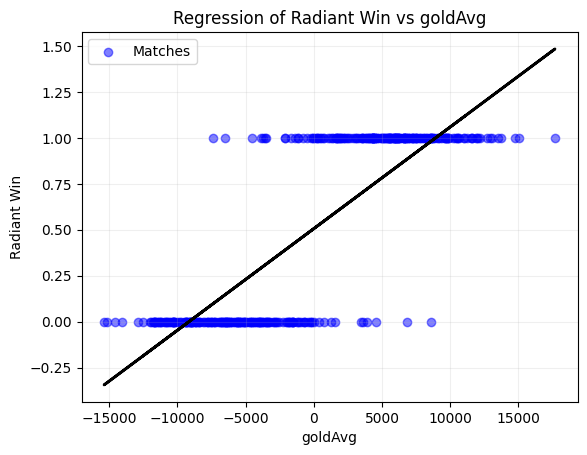

In [65]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b', alpha=0.5, label='Matches') 
plt.plot(X_test, y_pred, color ='k', linewidth=2) 

plt.xlabel('goldAvg')
plt.ylabel('Radiant Win')
plt.title('Regression of Radiant Win vs '+ 'goldAvg')
plt.legend()
plt.grid(alpha=0.2)
plt.show() 

In [66]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.25) 
regr = LinearRegression() 
regr.fit(X_train, y_train) 
print(regr.score(X_test, y_test))

0.8295828820135507


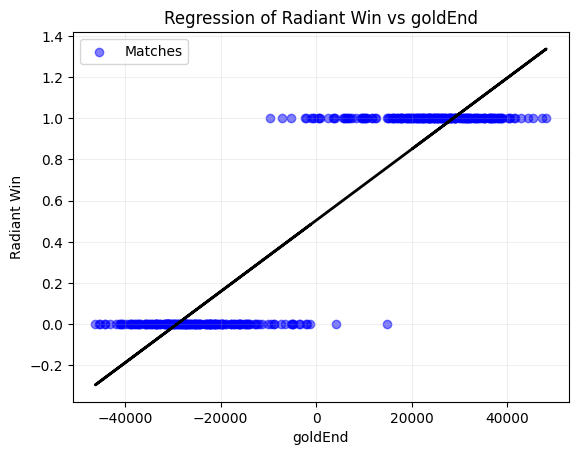

In [67]:
y_pred = regr.predict(X_test) 
plt.scatter(X_test, y_test, color ='b', alpha=0.5, label='Matches') 
plt.plot(X_test, y_pred, color ='k', linewidth=2) 

plt.xlabel('goldEnd')
plt.ylabel('Radiant Win')
plt.title('Regression of Radiant Win vs '+ 'goldEnd')
plt.legend()
plt.grid(alpha=0.2)
plt.show() 

**2.** **Discuss** the score you obtained! What do the results for the regression mean for the explanatory power of the gold variables? How can one interpret the graph?

**Write your observations here:** The regression scores show that goldEnd (0.84) explains match outcome much better than goldAvg (0.62). This means the final gold difference is a stronger predictor of winning than the average gold difference during the match.

The graphs confirm this: in the goldEnd plot, wins and losses are clearly separated: higher gold usually means a win, lower gold means a loss, with little overlap. This clean separation shows that goldEnd has higher explanatory power for the result.

### d) Testing our hypothesis

Finally, we can do our linear regression. This time, **use the newly created columns from 4.2 b)**. Use the **gold-related data** and the **kill/death ratios for X**, **worst kill/dath rations for X**, **standard deviation**, and the **difference in negativity for Y**.

In [68]:
# Define X and Y
# Feature matrix (X)
X = dataframe[[
    'goldAvg',
    'goldEnd',
    'avgKDR',
    'avgKDD',
    'worstKDR',
    'worstKDD',
    'devKDR',
    'devKDD'
]]

# Target vector (Y): 
Y = dataframe['diff']

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print(regr.score(X,Y))

0.0030917173846907176


### e) Discussion

What is the score? What does that number mean? Discuss possible reasons for this result.  
**Hint:** Take a peek at the labels.csv file and look at some of the most common negative words. 

**Write your observations here:** The regression produced a score of only 0.003, meaning that the model explains virtually none of the variation in negativity difference.

This suggests that performance indicators like gold and kill/death ratios are not good predictors of toxic behavior in chat. One reason could be that negative messages are often aimed at the opposing team, not necessarily reflecting frustration with one’s own performance.

Sometimes, toxic language is used regardless of performance, just to mock the enemy, both when losing and even more often when winning. If we look at labels.csv, many messages are trash talk or taunts to provoke the enemy, without real connection to how the game is going.

So overall, negativity is highly context-dependent and noisy, and it does not follow a clear linear pattern with game statistics.

# Feedback

We're always looking for improvements. Please share your feedback; tell us where you had difficulties or what you’d change to make things better.

**Note:** All feedback will be saved anonymous, so feel free to be open and honest!

**Please write your feedback here:**